## Live Cell Analysis – Three channel spot tracking

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy.ndimage as ndi

import pims
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.feature
import trackpy as tp
import pystackreg

### 1. Import and viewing

In [2]:
root = './data'

extension = 'nd'
c3 = False

c1_name = '561-488' # Camera 1, reference
c2_name = '488-561' # Camera 2, to be aligned
c3_name = '' # Camera 1, will not be aligned

In [3]:
def get_files(root, extension='nd'):
    '''
    '''
    files = sorted(glob.glob(f'{root}/*.{extension}'))
    files = [f.split('/')[-1] for f in files]
    files = [f.split('.')[0] for f in files]
    return files

In [4]:
files = get_files(root, extension)

# Image importing
@widgets.interact(file=widgets.Dropdown(options=files, description='File:'))
def f(file):
    global c_file, c1_image, c2_image
    if c3: global c3_image
        
    c_file = file
    
    if extension == 'tiff':
        c_image = skimage.io.imread(f'{root}/{c_file}.tiff').squeeze()
        c1_image = c_image[:,0,:,:,0].squeeze()
        c2_image = c_image[:,1,:,:,1].squeeze()
        if c3: c3_image = c_image[:,2,:,:,2].squeeze()
        
    if extension == 'nd':
        c1_image = skimage.io.imread(glob.glob(f'{root}/{c_file}*{c1_name}*.stk')[0])
        c2_image = skimage.io.imread(glob.glob(f'{root}/{c_file}*{c2_name}*.stk')[0])
        if c3: c3_image = skimage.io.imread(glob.glob(f'{root}/{c_file}*{c3_name}*.stk')[0])
    
    c1_max, c2_max = c1_image.max(), c2_image.max()
    
    # Interactive image viewer
    @widgets.interact(frame = widgets.IntSlider(min=1, max=c1_image.shape[0], description='Frame: '),
                      min_max_c1 = widgets.IntRangeSlider(value=(0, c1_max), min=0, max=c1_max, description='Min/Max 1: '),
                      min_max_c2 = widgets.IntRangeSlider(value=(0, c2_max), min=0, max=c2_max, description='Min/Max 2: '))
    def g(frame, min_max_c1, min_max_c2):
        c1_image_show = np.clip(c1_image[frame-1], *min_max_c1)
        c2_image_show = np.clip(c2_image[frame-1], *min_max_c2)
        if c3: c3_image_show = c3_image[frame-1]
        
        fig, ax = plt.subplots(1, 3 if c3 else 2, figsize=(15,10))
        ax[0].set_title('Channel 1')
        ax[0].imshow(c1_image_show, cmap='viridis')
        ax[1].set_title('Channel 2')
        ax[1].imshow(c2_image_show, cmap='viridis')
        if c3:
            ax[2].set_title('Channel 3')
            ax[2].imshow(c3_image_show)
        plt.show()

interactive(children=(Dropdown(description='File:', options=('Hela_pIM12_pIM52_sMH_Dox_1_4',), value='Hela_pIM…

### 2. Channel alignment

Description on which channels are taken and what is to be done

In [5]:
root_align = './align'

def get_align_image(root, name):
    '''
    '''
    file = get_files(root)[0]
    img = glob.glob(f'{root}/{file}*{name}*.stk')[0]
    img = skimage.io.imread(img)
    img = img[0] if img.ndim==3 else img
    return img

c1_align = get_align_image(root_align, c1_name)
c2_align = get_align_image(root_align, c2_name)

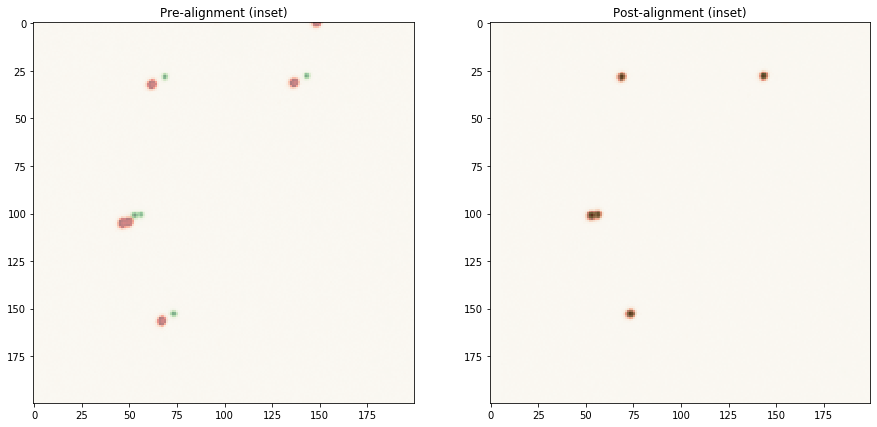

In [6]:
def align_matrix(img_ref, img_align):
    '''
    '''
    sr = pystackreg.StackReg(pystackreg.StackReg.SCALED_ROTATION)
    sr.register(img_ref, img_align)
    return sr

sr = align_matrix(c1_align, c2_align)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].set_title('Pre-alignment (inset)')
ax[0].imshow(c1_align[:200,:200], cmap='Greens')
ax[0].imshow(c2_align[:200,:200], cmap='Reds', alpha=0.5)
ax[1].set_title('Post-alignment (inset)')
ax[1].imshow(c1_align[:200,:200], cmap='Greens')
ax[1].imshow(sr.transform(c2_align)[:200,:200], cmap='Reds', alpha=0.5)
plt.show()

In [7]:
def align_image_stack(img, sr):
    '''
    '''
    if img.ndim!=2:
        img_align = [align_image(i, sr) for i in img]
        return np.asarray(img_align)
    return sr.transform(img)

c2_image = np.array([align_image_stack(img, sr) for img in c2_image])

### 3. Segmentation

#### Minimum projection

To reduce the impact of high intensity spots we perform a minimum projection – this leaves us with a single image. As c1/c2 were only used as definitions for channel alignments, one must select which channel should be used for nuclear, which for cytoplasmic segmentation.

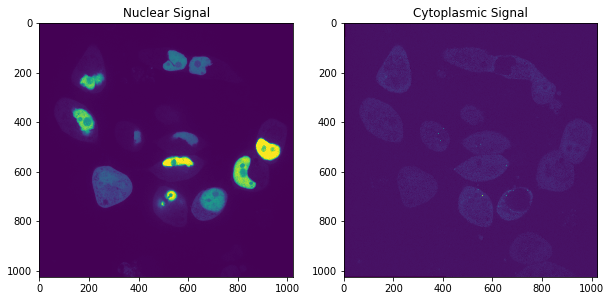

In [8]:
img_cytoplasm = c2_image
img_nucleus = c1_image
img_granules = None

img_cytoplasm = np.min(img_cytoplasm, axis=0)
img_nucleus = np.min(img_nucleus, axis=0)
if img_granules: img_granules = np.min(img_granules, axis=0)

fig, ax = plt.subplots(1, 3 if img_granules else 2, figsize=(10, 5))
ax[0].set_title('Nuclear Signal')
ax[0].imshow(img_nucleus, cmap='viridis')
ax[1].set_title('Cytoplasmic Signal')
ax[1].imshow(img_cytoplasm, cmap='viridis')
if img_granules:
    ax[2].set_title('Granular Signal')
    ax[2].imshow(img_granules[0], cmap='viridis')
plt.show()

#### Threshold by quantiles – nucleus

Smoothing helps to reduce unevenly shaped borders.

In [9]:
@widgets.interact(quantile = widgets.BoundedFloatText(value=0.95, min=0, max=1, step=0.01, description='Quantile: '))
def g(quantile):
    global img_thresh_nucleus
    
    img_smooth = skimage.filters.gaussian(img_nucleus, 2)
    img_quantile = np.quantile(img_smooth, quantile)
    img_thresh_nucleus = img_smooth > img_quantile

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title('Image')
    ax[0].imshow(img_nucleus, cmap='viridis')
    ax[1].set_title('Segmentation')
    ax[1].imshow(img_thresh_nucleus, cmap='viridis')
    plt.show()

interactive(children=(BoundedFloatText(value=0.95, description='Quantile: ', max=1.0, step=0.01), Output()), _…

#### Threshold by quantiles – cytoplasm


In [10]:
@widgets.interact(quantile = widgets.BoundedFloatText(value=0.70, min=0, max=1, step=0.05, description='Quantile: '))
def g(quantile):
    global img_thresh_cytoplasm
    
    img_smooth = skimage.filters.gaussian(img_cytoplasm, 2)
    img_quantile = np.quantile(img_smooth, quantile)
    img_thresh_cytoplasm = img_smooth > img_quantile
    img_thresh_cytoplasm = ndi.binary_fill_holes(img_thresh_cytoplasm)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title('Image')
    ax[0].imshow(img_cytoplasm, cmap='viridis')
    ax[1].set_title('Segmentation')
    ax[1].imshow(img_thresh_cytoplasm, cmap='viridis')
    plt.show()

interactive(children=(BoundedFloatText(value=0.7, description='Quantile: ', max=1.0, step=0.05), Output()), _d…

#### Threshold by quantiles – granules

In [ ]:
if img_granules:
    @widgets.interact(frame = widgets.IntSlider(value=1, min=1, max=len(img_granules)-1, description='Frame: '),
                      quantile = widgets.FloatSlider(value=0.95, min=0, max=1, step=0.01, description='Quantile: '))
    def g(frame, quantile):
        global var_quantile_granules, quantile_dist_transform

        img_smooth = skimage.filters.gaussian(img_granules[frame], 2)
        var_quantile_granules = np.quantile(img_smooth, quantile)

        def quantile_dist_transform(img, quantile, return_both=True):
            img_seg = img > quantile
            img_seg_dist = ndi.distance_transform_edt(img_seg)
            if return_both:
                return img_seg, img_seg_dist
            return img_seg_dist

        img_seg_granules, img_seg_granules_dist = quantile_dist_transform(img_smooth, var_quantile_granules)

        fig, ax = plt.subplots(1, 3, figsize=(15, 10))
        ax[0].set_title('Granular image')
        ax[0].imshow(img_granules[frame])
        ax[1].set_title('Granular segmentation')
        ax[1].imshow(img_seg_granules)
        ax[2].set_title('Granular distance transform')
        ax[2].imshow(img_seg_granules_dist)
        plt.show()

#### Find nuclear seeds

The following parameters can be altered:

- Sigma – Smoothing level. Increase it to reduce signal un-uniformities and make peak finding easier.
- Min_distance – Minimum distance between to peaks. Higher intensity peak will be used.
- Threshold_rel – Relative threshold in peak-proximity to be classified as peak.

In [11]:
@widgets.interact(
    sigma = widgets.BoundedIntText(value=10, min=0, max=20, description='Sigma: '),
    min_distance = widgets.BoundedIntText(value=50, min=1, max=500, description='Min. dist.: '),
    threshold_rel = widgets.BoundedFloatText(value=0.03, min=0, max=1, step=0.01, description='Rel. thresh.: ')
)
def g(sigma, min_distance, threshold_rel):
    global img_seeds
    
    img_smooth = skimage.filters.gaussian(img_nucleus, sigma)
    img_seeds = skimage.feature.peak_local_max(img_smooth,
                                               indices=False,
                                               min_distance=min_distance,
                                               threshold_rel=threshold_rel)
    img_seeds_dil = skimage.morphology.dilation(img_seeds, skimage.morphology.square(10))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(img_nucleus)
    plt.jet()
    plt.imshow(img_seeds_dil, alpha=0.5, cmap='viridis')
    plt.title(f'Spot count: {len(np.unique(skimage.morphology.label(img_seeds)))}')
    plt.show()

interactive(children=(BoundedIntText(value=10, description='Sigma: ', max=20), BoundedIntText(value=50, descri…

#### Watershed 

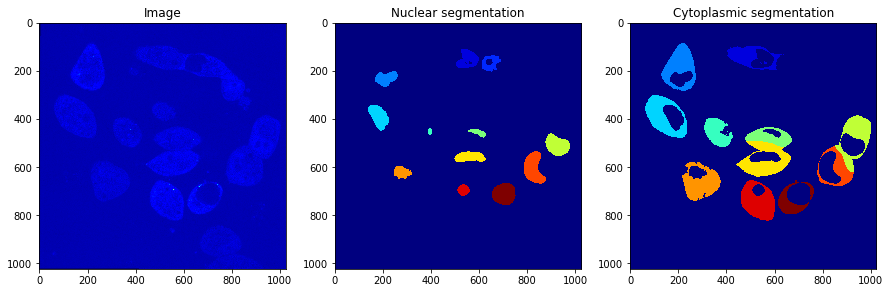

In [12]:
img_seeds = skimage.morphology.label(img_seeds)
img_seg_nucleus = skimage.segmentation.watershed(~img_thresh_nucleus, img_seeds, mask=img_thresh_nucleus)
img_seg_cytoplasm = skimage.segmentation.watershed(~img_thresh_cytoplasm, img_seg_nucleus, mask=img_thresh_cytoplasm)
img_seg_cytoplasm = np.where(img_seg_nucleus, 0, img_seg_cytoplasm)

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].set_title('Image')
ax[0].imshow(img_cytoplasm)
ax[1].set_title('Nuclear segmentation')
ax[1].imshow(img_seg_nucleus)
ax[2].set_title('Cytoplasmic segmentation')
ax[2].imshow(img_seg_cytoplasm)
plt.show()

### 4. Spot tracking

1. Assume all SunTag spots have mRNAs – necessity of unbiased acquisition. Tracking will include count per cell as well as average brightness.
2. Track mRNAs and measure SunTag proximity – i.e. having two tracks.


The resulting dataframe contains the following "measurements":
- frame – image number in a sequence
- x, y – dimensionality of the image
- mass – total integrated brightness of the blob
- size – radius of gyration of its gaussian-like profile
- ecc – eccentricity (0 is circular)
- raw_mass – total integrated brightness in raw_image

#### Spot detection
Parameters:
- Image – frame in time series of images.
- Diameter – expected blob diameter (actual size still measured). When in doubt, round up.
- Minmass – the minimum integrated brightness.
- Maxsize – maximum radius of gyration.
- Percentile – spots must be above percentile. Default is 64.

In [13]:
# Channel 1
f1 = pims.Frame(c1_image)

@widgets.interact(img_slice = widgets.IntSlider(value=1, min=1, max=len(f1), step=1, description='Frame: '),
          min_max = widgets.IntRangeSlider(value=(0, f1.max()), min=0, max=f1.max(), description='Min/Max: '),
          diameter = widgets.BoundedIntText(value=13, min=1, max=29, step=2, description='Diameter: '),
          minmass = widgets.BoundedIntText(value=5_000, min=0, max=20_000, step=100, description='Minmass: '),
          maxsize = widgets.BoundedFloatText(value=2.5, min=0, max=100, step=0.1, description='Maxsize: '),
         )
def g(img_slice, min_max, diameter, minmass, maxsize):
    global var1_diameter, var1_minmass, var1_maxsize
    var1_diameter = diameter
    var1_minmass = minmass
    var1_maxsize = maxsize
    
    df_single = tp.locate(f1[img_slice-1], diameter=diameter, minmass=minmass, maxsize=maxsize, engine='numba')
    
    plt.figure(figsize=(15, 10))
    plt.title('Channel 1')
    tp.annotate(df_single, np.clip(f1[img_slice-1], *min_max), color='m', imshow_style={'cmap':'viridis'})

interactive(children=(IntSlider(value=1, description='Frame: ', max=30, min=1), IntRangeSlider(value=(0, 60080…

In [14]:
# Channel 2
f2 = pims.Frame(c2_image)

@widgets.interact(img_slice = widgets.IntSlider(value=1, min=0, max=len(f2)-1, step=1, description='Frame: '),
          min_max = widgets.IntRangeSlider(value=(0, f2.max()), min=0, max=f2.max(), description='Min/Max: '),
          diameter = widgets.BoundedIntText(value=13, min=1, max=29, step=2, description='Diameter: '),
          minmass = widgets.BoundedIntText(value=10_000, min=0, max=20_000, step=100, description='Minmass: '),
          maxsize = widgets.BoundedFloatText(value=2.5, min=0, max=100, step=0.1, description='Maxsize: '),
         )
def g(img_slice, min_max, diameter, minmass, maxsize):
    global var2_diameter, var2_minmass, var2_maxsize
    var2_diameter = diameter
    var2_minmass = minmass
    var2_maxsize = maxsize
    
    df_single = tp.locate(f2[img_slice], diameter=diameter, minmass=minmass, maxsize=maxsize, engine='numba')
    
    plt.figure(figsize=(15, 10))
    plt.title('Channel 1')
    tp.annotate(df_single, np.clip(f2[img_slice], *min_max), color='m', imshow_style={'cmap':'viridis'}) #or hsv

interactive(children=(IntSlider(value=1, description='Frame: ', max=29), IntRangeSlider(value=(0, 25879), desc…

In [16]:
# Run detection on all frames
df1 = tp.batch(f1, diameter=var1_diameter, minmass=var1_minmass, maxsize=var1_maxsize, engine='numba')
df2 = tp.batch(f2, diameter=var2_diameter, minmass=var2_minmass, maxsize=var2_maxsize, engine='numba')

Frame 29: 33 features


#### Linking

Parameters:
* Linking particles
    - Search range: maximum distance features can move between frames
    - Memory: maximum number of frames during which a feature can vanish, then reappear nearby, and be considered the same particle
    - Currently, no neighbor or movement predictions are used to increase performance. This can be changed if the tracks do not correspond to expected trajectories. Options are 'KDTree' or 'BTree' for neighbor search and 'NullPredict', 'NearestVelocityPredict', 'DriftPredict', 'ChannelPredict' as predictions. See [this](https://github.com/soft-matter/trackpy/blob/master/trackpy/predict.py) for more details.
    
* Filter trajectories
    - Threshold: minimum number of frames for spot to survive

Frame 29: 33 trajectories present.
Before: 297
After: 37


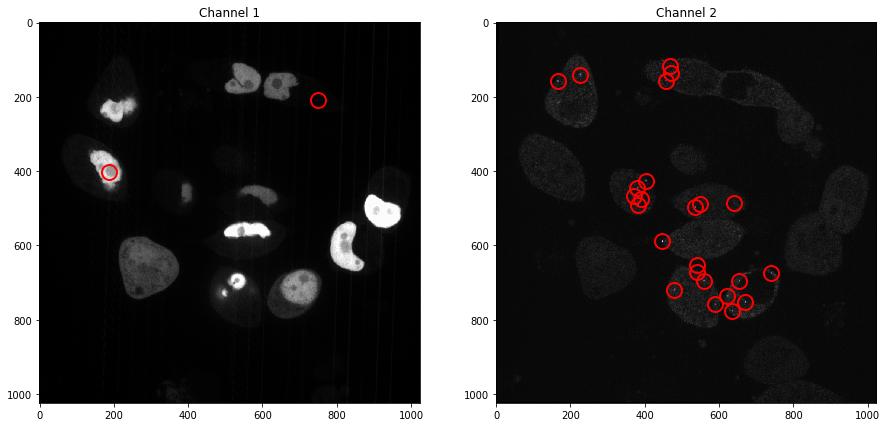

In [17]:
var_search_range = 10
var_memory = 3
var_threshold = 5

def link_and_filter(df, search_range, memory, threshold):
    df = tp.link_df(df, search_range=search_range, memory=memory)
    print('Before:', df['particle'].nunique())
    df = tp.filter_stubs(df, threshold=threshold)
    print('After:', df['particle'].nunique())
    return df

df1 = link_and_filter(df1, var_search_range, var_memory, var_threshold)
df2 = link_and_filter(df2, var_search_range, var_memory, var_threshold)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].set_title('Channel 1')
tp.annotate(df1[df1['frame'] == 0], f1[0], ax=ax[0])
ax[1].set_title('Channel 2')
tp.annotate(df2[df2['frame'] == 0], f2[0], ax=ax[1])
plt.show()

#### Drift subtraction
The drift is calculated to account for movements of all spots over frames, i.e. caused by cellular or microscopic stage movements. No parameters are necessary. 

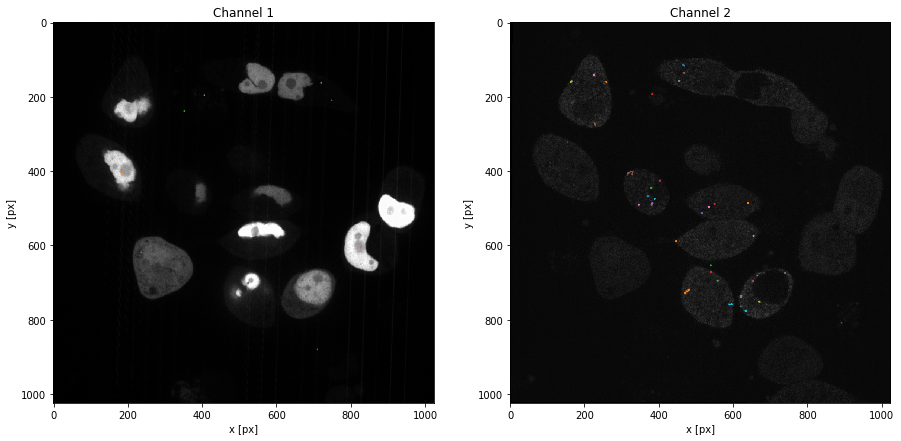

In [18]:
def remove_drift(df):
    df_drift = tp.compute_drift(df)
    df = tp.subtract_drift(df.copy(), df_drift)
    return df

df1 = remove_drift(df1)
df2 = remove_drift(df2)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].set_title('Channel 1')
tp.plot_traj(df1, superimpose=f1[0], ax=ax[0])
ax[1].set_title('Channel 2')
tp.plot_traj(df2, superimpose=f2[0], ax=ax[1])
plt.show()

### 5. Measure other channels and cell number

As currently only one channel is tracked, one has to calculate the (potential) spot intensity in the second – untracked – channel. In addition, the tracks are assigned to their belonging cells. If a track is detected in the background it is sacrificed.

In [19]:
# Cellular assignment
def assign_cell(df, img_seg):
    def _get_value(img, y, x):
        return img[int(round(y)), int(round(x))]
    
    if df.empty: return df
    
    df['cell'] = df.apply(lambda row: _get_value(img_seg, row['y'], row['x']), axis=1)
    print('Before:', df['particle'].nunique())
    df = df[df['cell']!=0]
    print('After:', df['particle'].nunique())
    return df

# TODO take image stack instead of recomputing
def assign_granule(df, img, quantile):
    def _get_value(img, f, y, x, quantile):
        return img[int(f), int(y), int(x)]
    
    img = skimage.filters.gaussian(img, 2)
    img = quantile_dist_transform(img, var_quantile_granules, False)
    
    df['granule'] = df.apply(lambda row: _get_value(img, row['frame'], row['y'], row['x'], quantile), axis=1)
    return df

df1 = assign_cell(df1, img_seg_cytoplasm)
df2 = assign_cell(df2, img_seg_cytoplasm)

if img_granules:
    df1 = assign_granule(df1, img_granules, var_quantile_granules)
    df2 = assign_granule(df2, img_granules, var_quantile_granules)

Before: 8
After: 0
Before: 37
After: 33


### 6. Output metrics

Different outputs for both types of measurements:
1. One row is one track
2. Number of frames colocalizing
3. Number of frames not colocalizing – maybe easier to do each frame and not sum up
4. Intensities in both channels

1. Assume all SunTag spots have mRNAs – necessity of unbiased acquisition. Tracking will include count per cell as well as average brightness.
2. Track mRNAs and measure SunTag proximity – i.e. having two tracks.

In [20]:
df1['channel'] = 1
df2['channel'] = 2
df = pd.concat([df1, df2])

df['file'] = c_file

In [ ]:
root_out = './out'

os.makedirs(root_out, exist_ok=True)
df.to_csv(f'./out/{c_file}.csv', index=False)

In [ ]:
config_vars = {}

# ************ 01 ************ #
# ****** PREPROCESSING ******* #
# **************************** #

config_vars["root_directory"] = '/home/jccaicedo/nucleus_segmentation/'
config_vars["max_training_images"] = 0
config_vars["create_split_files"] = False
config_vars["training_fraction"] = 0.5
config_vars["validation_fraction"] = 0.25
config_vars["transform_images_to_PNG"] = True
config_vars["pixel_depth"] = 8
config_vars["min_nucleus_size"] = 25
config_vars["boundary_size"] = 2
config_vars["augment_images"] =  False
config_vars["elastic_points"] = 16
config_vars["elastic_distortion"] = 5
config_vars["elastic_augmentations"] = 10
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
config_vars["learning_rate"] = 1e-4
config_vars["epochs"] = 15
config_vars["steps_per_epoch"] = 500
config_vars["batch_size"] = 10
config_vars["val_batch_size"] = 10
config_vars["rescale_labels"] = True
config_vars["crop_size"] = 256
config_vars["cell_min_size"] = 16

config_vars["boundary_boost_factor"] = 1
config_vars["object_dilation"] = 3

# **************************** #
# ******** FINAL SETUP ******* #
# **************************** #

config_vars = utils.dirtools.setup_working_directories(config_vars)

In [ ]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)